# Conformal Experiment: Increase Oracles
- OvA
- Softmax

**Experiment**


In [25]:
import json

import numpy as np
import torch
import matplotlib.pyplot as plt

from scipy import stats

In [26]:
n_classes = 10
n_experts = 10

# Metric Calculation

In [27]:
def get_expert_prediction(experts, prediction_set_i, method="voting"):
    ensemble_expert_pred_i = np.array(experts_test)[prediction_set_i][:, i]
    if method == "voting":
        exp_prediction = stats.mode(ensemble_expert_pred_i).mode if len(ensemble_expert_pred_i)!=0 else []
        
    if method == "last": 
        exp_prediction = ensemble_expert_pred_i[-1] if len(ensemble_expert_pred_i)!=0 else []
        
    if method == "random":
        idx = np.random.randint(len(ensemble_expert_pred_i)) if len(ensemble_expert_pred_i)!=0 else -1
        exp_prediction = ensemble_expert_pred_i[idx] if idx!=-1 else []
        
    return exp_prediction

## OvA

In [28]:
# np.arange(0,10)

In [61]:
# === OvA ===
confs = []
exps = []
true = []
path = "ova_increase_oracle_v2/"

k_list = [1,3,5,7,9] #np.arange(0,10)
seed = 948

log_path = "increase_oracles_v2_oracle_classes_k_9seed_" + str(seed)
oracle_classes = []
with open(path + log_path + '.json', 'r') as f:
    log = json.load(f)
for k in k_list:
    print("oracle_classes {}".format(log["oracles_classes"][str(k)]))
    oracle_classes.append(log["oracles_classes"][str(k)])
    print("oracle positions {}".format(log["oracles_positions"][str(k)]))
    model_name = '_k_' + str(k)
    seed_name = 'seed_' + str(seed)
    with open(path + 'confidence_multiple_experts' + model_name + seed_name + '.txt', 'r') as f:
        conf = json.loads(json.load(f))
    with open(path + 'expert_predictions_multiple_experts' + model_name + seed_name + '.txt', 'r') as f:
        exp_pred = json.loads(json.load(f))
    with open(path + 'true_label_multiple_experts' + model_name + seed_name + '.txt', 'r') as f:
        true_label = json.loads(json.load(f))
    true.append(true_label['test'])
    exps.append(exp_pred['test'])
    c = torch.tensor(conf['test'])
    # DANI Correction ===
    c = c.sigmoid()
    # DANI Correction ===
    confs.append(c)

    # print(np.array(exp_pred['test']).T[:5,:])
    # print(true_label["test"][:5])
    # print(c[:5,10:])
    # break

oracle_classes [8, 5, 0, 6, 4]
oracle positions [1, 9]
oracle_classes [1, 8, 5, 2, 9]
oracle positions [4, 9, 6, 7]
oracle_classes [4, 0, 2, 8, 1]
oracle positions [7, 4, 5, 3, 8, 2]
oracle_classes [7, 9, 6, 4, 8]
oracle positions [5, 2, 7, 8, 6, 3, 1, 0]
oracle_classes [0, 5, 6, 2, 7]
oracle positions [9, 4, 2, 1, 3, 6, 0, 7, 8, 5]


In [30]:
np.array(exps[0])[:,:5]

array([[7, 7, 1, 3, 9],
       [3, 8, 8, 0, 6],
       [2, 2, 3, 2, 2],
       [1, 1, 9, 1, 2],
       [7, 1, 3, 2, 2],
       [1, 2, 2, 2, 2],
       [9, 7, 2, 2, 1],
       [2, 9, 1, 7, 3],
       [7, 3, 9, 7, 7],
       [1, 8, 8, 0, 6]])

In [33]:
true[0][:5]

[3, 8, 8, 0, 6]

In [34]:
n_val = int(0.8 * len(true[0]))
n_test = len(true[0]) - n_val
print("N val:{}".format(n_val))
print("N test:{}".format(n_test))

# for shuffling
idx = np.array([1]*n_val + [0]*(len(true[0]) - n_val)) > 0
assert int(sum(idx)) == n_val
np.random.shuffle(idx)

N val:7372
N test:1844


In [35]:
k_list = [2,4,6,8,10] #np.arange(0,10)
alpha = 0.1
n_classes = 10
n_experts = 10
n_classes_exp = n_classes + n_experts


In [41]:
# Method dict ===
method_list_ova = ["standard", "last", "random", "voting"]
method_dict_ova = {"standard": [],
               "last": [],
               "random": [],
               "voting": []}

for method in method_list_ova:
    print("Method: {}\n".format(method))
    for i, k in enumerate(k_list):
        # =============
        # = Get Probs =
        # =============
        set_size = []
        deferred_label = []

        probs = confs[i]
        experts = exps[i]
        #experts = experts[::-1]  # reverse order!
        y_true = true[i]

        # Val/Calibration ===
        probs_val = probs[idx, n_classes:]
        experts_val = [np.array(exp)[idx].tolist() for exp in experts]
        y_true_val = np.array(y_true)[idx].astype(list)

        # Test ===
        probs_test = probs[~idx, n_classes:]
        experts_test = [np.array(exp)[~idx].tolist() for exp in experts]
        y_true_test = np.array(y_true)[~idx].astype(list)


        # =============
        # = Conformal =
        # =============

        # Calculate Q_hat ===

        # === Only on deferred samples
        _, predicted = torch.max(probs[idx].data, 1)
        r = (predicted >= n_classes_exp - n_experts)

        # Filter 
        probs_experts = probs_val[r]
        experts_val = [np.array(exp)[r] for exp in experts_val]
        y_true_val = np.array(y_true_val)[r]

        # Model expert probs ===
        # Sort J model outputs for experts
        sort, pi = probs_experts.sort(dim=1, descending=True)

        # Correctness experts ===
        # Check if experts are correct 
        correct_exp = (np.array(experts_val) == np.array(y_true_val)).T
        # idx for correct experts: [[0,1,2], [1,2], [], ...]
        correct_exp_idx = [np.where(correct_exp_i)[0] for correct_exp_i in correct_exp]

        # obtain the last expert to be retrieved. If empty, then add all values.
        # indexes are not the real expert index, but the sorted indexes, e.g. [[1, 0 ,2],  [1,0], [], ...]
        pi_corr_exp = [probs_experts[i, corr_exp].sort(descending=True)[1] for i, corr_exp in enumerate(correct_exp)]
        pi_corr_exp_stop = [pi_corr_exp_i[-1] if len(pi_corr_exp_i)!=0 else -1 for pi_corr_exp_i in pi_corr_exp]  # last expert

        # obtain real expert index back, e.g. [2,1,-1,...]
        pi_stop = [correct_exp_idx[i][pi_corr_exp_stop_i] if len(correct_exp_idx[i])!=0 else -1 for i, pi_corr_exp_stop_i in enumerate(pi_corr_exp_stop)]

        scores = sort.cumsum(dim=1).gather(1, pi.argsort(1))[range(len(torch.tensor(pi_stop))), torch.tensor(pi_stop)]
        n_quantile = r.sum()
        qhat = torch.quantile(scores, np.ceil((n_quantile + 1) * (1 - alpha)) / n_quantile, interpolation="higher")
        print("Q_hat {}: {}".format(k, qhat))


        # =============
        # = Metrics =
        # =============

        # === Initalize ====

        correct = 0
        correct_sys = 0
        exp = 0
        exp_total = 0
        total = 0
        real_total = 0
        alone_correct = 0

        # Individual Expert Accuracies === #
        expert_correct_dic = {k: 0 for k in range(len(experts_test))}
        expert_total_dic = {k: 0 for k in range(len(experts_test))}

        probs_test_exp = probs_test
        probs_test_model = probs[~idx]

        # Predicted value 
        _, predicted = torch.max(probs_test_model.data, 1)

        # Classifier alone prediction
        _, prediction = torch.max(probs_test_model.data[:, :(n_classes_exp - n_experts)],1)

        labels = y_true_test
        for i in range(0, n_test):
            r = (predicted[i].item() >= n_classes_exp - n_experts)
            alone_correct += (prediction[i] == labels[i]).item()

            # Non-deferred 
            if r == 0:
                total += 1
                correct += (predicted[i] == labels[i]).item()
                correct_sys += (predicted[i] == labels[i]).item()

            # Deferred 
            if r == 1:
                deferred_label.append(labels[i])
                
                # Non Conformal prediction ===
                if method=="standard":
                    deferred_exp = (predicted[i] - n_classes).item()  # reverse order, as in loss function
                    exp_prediction = experts_test[deferred_exp][i]
                    
                    # Conformal prediction ===        
                else:                
                    # Sort J model outputs for experts. sorted probs and sorted indexes
                    sort_i, pi_i = probs_test_exp[i].sort(descending=True)
                    # Get last sorted index to be below Q_hat
                    pi_stop_i = (sort_i.cumsum(dim=0) <= qhat).sum()
                    # Prediction sets
                    prediction_set_i = (pi_i[:(pi_stop_i)]).numpy()  # not allow empty sets        

                    # - Get expert prediction depending on method
                    # ======
                    exp_prediction = get_expert_prediction(experts_test, prediction_set_i, method=method)
                    # ======
                    
                    set_size.append(len(prediction_set_i))



                # Deferral accuracy: No matter expert ===
                exp += (exp_prediction == labels[i])
                exp_total += 1
                # Individual Expert Accuracy ===
                # expert_correct_dic[deferred_exp] += (exp_prediction == labels[i].item())
                # expert_total_dic[deferred_exp] += 1
                #
                correct_sys += (exp_prediction == labels[i])

            real_total += 1
            

        #  ===  Coverage  === #    
        cov = 100 * total / real_total

        #  === Individual Expert Accuracies === #
        expert_accuracies = {"expert_{}".format(str(k)): 100 * expert_correct_dic[k] / (expert_total_dic[k] + 0.0002) for k
                     in range(len(experts_test))}

        # Add expert accuracies dict
        to_print = {"coverage": cov,
                    "system_accuracy": 100 * correct_sys / real_total,
                    "expert_accuracy": 100 * exp / (exp_total + 0.0002),
                    "classifier_accuracy": 100 * correct / (total + 0.0001),
                    "alone_classifier": 100 * alone_correct / real_total,
                    "set_size": set_size,
                    "avg_set_size": np.mean(set_size),
                    "q_hat": qhat,
                    "deferred_label": deferred_label}
        #print(to_print, flush=True)

        # Save to method dict === 
        method_dict_ova[method].append(to_print)



Method: standard

Q_hat 2: 1.9999918937683105


/Users/dbarrejon/miniconda3/envs/l2d-conformal/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dbarrejon/miniconda3/envs/l2d-conformal/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Q_hat 4: 3.9999923706054688
Q_hat 6: 5.999989986419678
Q_hat 8: 7.999989032745361
Q_hat 10: 9.999995231628418
Method: last

Q_hat 2: 1.9999918937683105
Q_hat 4: 3.9999923706054688
Q_hat 6: 5.999989986419678
Q_hat 8: 7.999989032745361
Q_hat 10: 9.999995231628418
Method: random

Q_hat 2: 1.9999918937683105
Q_hat 4: 3.9999923706054688
Q_hat 6: 5.999989986419678
Q_hat 8: 7.999989032745361
Q_hat 10: 9.999995231628418
Method: voting

Q_hat 2: 1.9999918937683105
Q_hat 4: 3.9999923706054688
Q_hat 6: 5.999989986419678
Q_hat 8: 7.999989032745361
Q_hat 10: 9.999995231628418


In [57]:
def_label_list = [method_dict_ova["standard"][i]["deferred_label"] for i in range(len(k_list))]

In [66]:
oracle_classes[0]

[8, 5, 0, 6, 4]

In [70]:
k_list

[1, 3, 5, 7, 9]

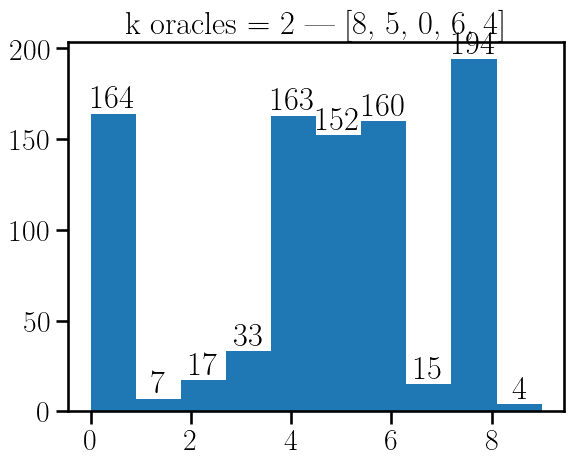

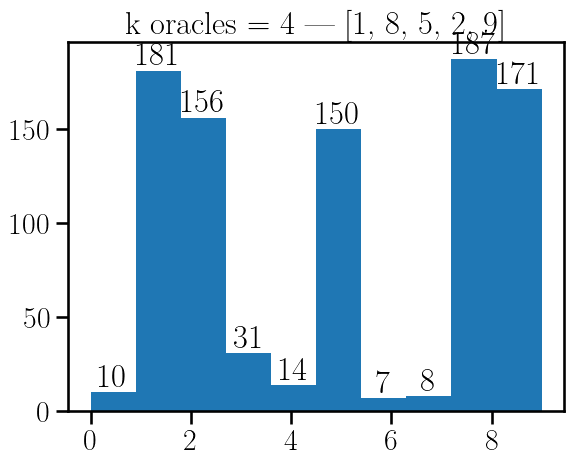

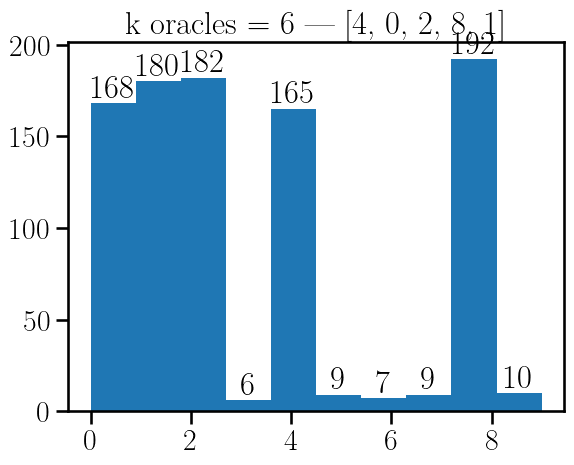

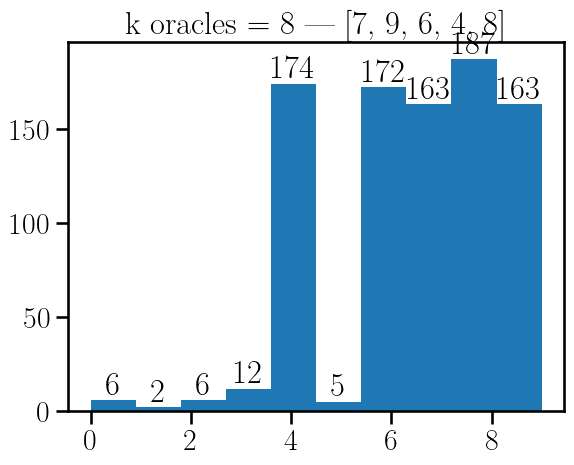

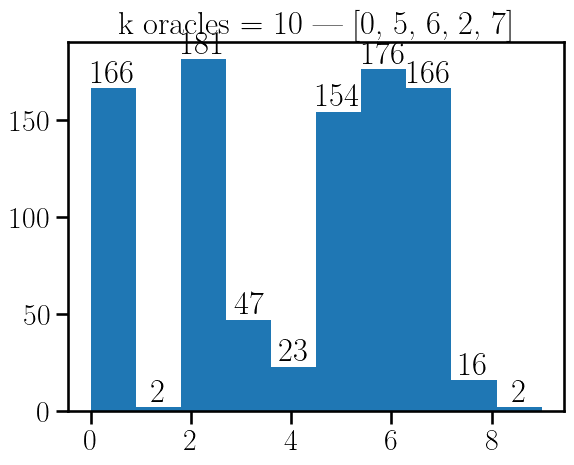

In [71]:
for i,k in enumerate(k_list):
    plt.figure()
    counts, edges, bars = plt.hist(def_label_list[i])
    plt.title("k oracles = {} | {} ".format(k+1, oracle_classes[i]))
    plt.bar_label(bars)


## Softmax

In [85]:
# === Softmax ===
n_classes = 10
probs_softmax = []
confs = []
exps = []
true = []

path = "softmax_increase_oracle_v2/"
n_experts = 10
seed = 436
k_list = [1,3,5,7,9]
log_path = "increase_oracles_v2_oracle_classes_k_9seed_" + str(seed)

with open(path + log_path + '.json', 'r') as f:
    log = json.load(f)
for k in k_list:
    print("oracle_classes {}".format(log["oracles_classes"][str(k)]))
    print("oracle positions {}".format(log["oracles_positions"][str(k)]))
    
    model_name = '_k_' + str(k)
    seed_name = 'seed_' + str(seed)
    with open(path + 'confidence_multiple_experts' + model_name + seed_name + '.txt', 'r') as f:
        conf = json.loads(json.load(f))
    with open(path + 'expert_predictions_multiple_experts' + model_name + seed_name + '.txt', 'r') as f:
        exp_pred = json.loads(json.load(f))
    with open(path + 'true_label_multiple_experts' + model_name + seed_name + '.txt', 'r') as f:
        true_label = json.loads(json.load(f))
    true.append(true_label['test'])
    exps.append(exp_pred['test'])
    c = torch.tensor(conf['test'])
    print(c.shape)
    # DANI Correction ===
    c = c.softmax(dim=1)
    
    probs_softmax.append(c)
    # DANI Correction ===

    temp = 0
    for i in range(n_experts):
        temp += c[:, (n_classes + n_experts) - (i + 1)]
    prob = c / (1.0 - temp).unsqueeze(-1)
    confs.append(prob)

    # print(np.array(exp_pred['test']).T[:5,:])
    # print(true_label["test"][:5])
    # print(c[:5,10:])
    # break


oracle_classes [6, 7, 9, 1, 8]
oracle positions [5, 3]
torch.Size([9216, 20])
oracle_classes [3, 4, 9, 8, 0]
oracle positions [3, 4, 6, 5]
torch.Size([9216, 20])
oracle_classes [5, 0, 2, 4, 6]
oracle positions [6, 2, 3, 0, 9, 7]
torch.Size([9216, 20])
oracle_classes [6, 4, 7, 0, 3]
oracle positions [7, 0, 6, 2, 4, 8, 3, 5]
torch.Size([9216, 20])
oracle_classes [1, 6, 8, 3, 5]
oracle positions [9, 0, 5, 6, 3, 4, 2, 1, 7, 8]
torch.Size([9216, 20])


In [86]:
np.array(exps[0])[:,:10]

array([[4, 4, 0, 3, 5, 4, 4, 3, 4, 3],
       [3, 2, 3, 4, 3, 5, 2, 2, 0, 5],
       [2, 5, 5, 5, 5, 4, 2, 5, 4, 5],
       [5, 8, 8, 0, 6, 6, 1, 6, 0, 1],
       [0, 3, 4, 5, 3, 0, 3, 2, 4, 0],
       [0, 8, 8, 2, 6, 6, 1, 6, 5, 1],
       [3, 5, 5, 5, 4, 5, 0, 0, 5, 5],
       [3, 3, 2, 2, 3, 4, 3, 3, 4, 4],
       [3, 0, 2, 0, 3, 3, 3, 2, 4, 4],
       [4, 3, 0, 0, 5, 0, 3, 5, 4, 4]])

In [87]:
true[0][:10]

[3, 8, 8, 0, 6, 6, 1, 6, 3, 1]

In [15]:
# Method dict ===
method_list_softmax = ["standard", "last", "random", "voting"]
method_dict_softmax = {"standard": [],
               "last": [],
               "random": [],
               "voting": []}

for method in method_list_softmax:
                        
    set_size = []
    print("Method: {}\n".format(method))
    for i, k in enumerate(k_list):
        # =============
        # = Get Probs =
        # =============

        probs = probs_softmax[i]
        experts = exps[i]
        #experts = experts[::-1]  # reverse order!
        y_true = true[i]

        # Val/Calibration ===
        probs_val = probs[idx, n_classes:]
        experts_val = [np.array(exp)[idx].tolist() for exp in experts]
        y_true_val = np.array(y_true)[idx].astype(list)

        # Test ===
        probs_test = probs[~idx, n_classes:]
        experts_test = [np.array(exp)[~idx].tolist() for exp in experts]
        y_true_test = np.array(y_true)[~idx].astype(list)


        # =============
        # = Conformal =
        # =============

        # Calculate Q_hat ===

        # === Only on deferred samples
        _, predicted = torch.max(probs[idx].data, 1)
        r = (predicted >= n_classes_exp - n_experts)

        # Filter 
        probs_experts = probs_val[r]
        experts_val = [np.array(exp)[r] for exp in experts_val]
        y_true_val = np.array(y_true_val)[r]

        # Model expert probs ===
        # Sort J model outputs for experts
        sort, pi = probs_experts.sort(dim=1, descending=True)

        # Correctness experts ===
        # Check if experts are correct 
        correct_exp = (np.array(experts_val) == np.array(y_true_val)).T
        # idx for correct experts: [[0,1,2], [1,2], [], ...]
        correct_exp_idx = [np.where(correct_exp_i)[0] for correct_exp_i in correct_exp]

        # obtain the last expert to be retrieved. If empty, then add all values.
        # indexes are not the real expert index, but the sorted indexes, e.g. [[1, 0 ,2],  [1,0], [], ...]
        pi_corr_exp = [probs_experts[i, corr_exp].sort(descending=True)[1] for i, corr_exp in enumerate(correct_exp)]
        pi_corr_exp_stop = [pi_corr_exp_i[-1] if len(pi_corr_exp_i)!=0 else -1 for pi_corr_exp_i in pi_corr_exp]  # last expert

        # obtain real expert index back, e.g. [2,1,-1,...]
        pi_stop = [correct_exp_idx[i][pi_corr_exp_stop_i] if len(correct_exp_idx[i])!=0 else -1 for i, pi_corr_exp_stop_i in enumerate(pi_corr_exp_stop)]

        scores = sort.cumsum(dim=1).gather(1, pi.argsort(1))[range(len(torch.tensor(pi_stop))), torch.tensor(pi_stop)]
        n_quantile = r.sum()
        qhat = torch.quantile(scores, np.ceil((n_quantile + 1) * (1 - alpha)) / n_quantile, interpolation="higher")

        print("Q_hat {}: {}".format(k, qhat))


        # =============
        # = Metrics =
        # =============

        # === Initalize ====

        correct = 0
        correct_sys = 0
        exp = 0
        exp_total = 0
        total = 0
        real_total = 0
        alone_correct = 0

        # Individual Expert Accuracies === #
        expert_correct_dic = {k: 0 for k in range(len(experts_test))}
        expert_total_dic = {k: 0 for k in range(len(experts_test))}

        probs_test_exp = probs_test
        probs_test_model = probs[~idx]

        # Predicted value 
        _, predicted = torch.max(probs_test_model.data, 1)

        # Classifier alone prediction
        _, prediction = torch.max(probs_test_model.data[:, :(n_classes_exp - n_experts)],1)

        labels = y_true_test
        for i in range(0, n_test):
            r = (predicted[i].item() >= n_classes_exp - n_experts)
            alone_correct += (prediction[i] == labels[i]).item()

            # Non-deferred 
            if r == 0:
                total += 1
                correct += (predicted[i] == labels[i]).item()
                correct_sys += (predicted[i] == labels[i]).item()

            # Deferred 
            if r == 1:
                # Non Conformal prediction ===
                if method=="standard":
                    deferred_exp = (predicted[i] - n_classes).item()  # reverse order, as in loss function
                    exp_prediction = experts_test[deferred_exp][i]
                    
                    # Conformal prediction ===        
                else:                
                    # Sort J model outputs for experts. sorted probs and sorted indexes
                    sort_i, pi_i = probs_test_exp[i].sort(descending=True)
                    # Get last sorted index to be below Q_hat
                    pi_stop_i = (sort_i.cumsum(dim=0) <= qhat).sum()
                    # Prediction sets
                    prediction_set_i = (pi_i[:(pi_stop_i)]).numpy()  # not allow empty sets        

                    # - Get expert prediction depending on method
                    # ======
                    exp_prediction = get_expert_prediction(experts_test, prediction_set_i, method=method)
                    # ======
                    
                    set_size.append(len(prediction_set_i))



                # Deferral accuracy: No matter expert ===
                exp += (exp_prediction == labels[i])
                exp_total += 1
                # Individual Expert Accuracy ===
                # expert_correct_dic[deferred_exp] += (exp_prediction == labels[i].item())
                # expert_total_dic[deferred_exp] += 1
                #
                correct_sys += (exp_prediction == labels[i])

            real_total += 1

        #  ===  Coverage  === #    
        cov = 100 * total / real_total

        #  === Individual Expert Accuracies === #
        expert_accuracies = {"expert_{}".format(str(k)): 100 * expert_correct_dic[k] / (expert_total_dic[k] + 0.0002) for k
                     in range(len(experts_test))}

        # Add expert accuracies dict
        to_print = {"coverage": cov,
                    "system_accuracy": 100 * correct_sys / real_total,
                    "expert_accuracy": 100 * exp / (exp_total + 0.0002),
                    "classifier_accuracy": 100 * correct / (total + 0.0001),
                    "alone_classifier": 100 * alone_correct / real_total,
                    "set_size": set_size,
                    "avg_set_size": np.mean(set_size),
                    "q_hat": qhat}
        #print(to_print, flush=True)

        # Save to method dict === 
        method_dict_softmax[method].append(to_print)



Method: standard

Q_hat 1: 0.7101787328720093
Q_hat 3: 0.8219596147537231
Q_hat 5: 0.8704085350036621
Q_hat 7: 0.9002062082290649
Q_hat 9: 0.9146519899368286
Method: last

Q_hat 1: 0.7101787328720093
Q_hat 3: 0.8219596147537231
Q_hat 5: 0.8704085350036621
Q_hat 7: 0.9002062082290649
Q_hat 9: 0.9146519899368286
Method: random

Q_hat 1: 0.7101787328720093
Q_hat 3: 0.8219596147537231
Q_hat 5: 0.8704085350036621
Q_hat 7: 0.9002062082290649
Q_hat 9: 0.9146519899368286
Method: voting

Q_hat 1: 0.7101787328720093
Q_hat 3: 0.8219596147537231
Q_hat 5: 0.8704085350036621
Q_hat 7: 0.9002062082290649
Q_hat 9: 0.9146519899368286


## Plot results

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import rc

# # === Latex Options === #
rc('font', family='serif')
rc('text', usetex=True)

# === Matplotlib Options === #
cm = plt.cm.get_cmap('tab10')
plot_args = {"marker": "o",
             "markeredgecolor": "k",
             "markersize": 10,
             "linewidth": 8
             }
sns.set_context("talk", font_scale=1.3)
fig_size = (7,7)


In [17]:
# np.arange(1,11)

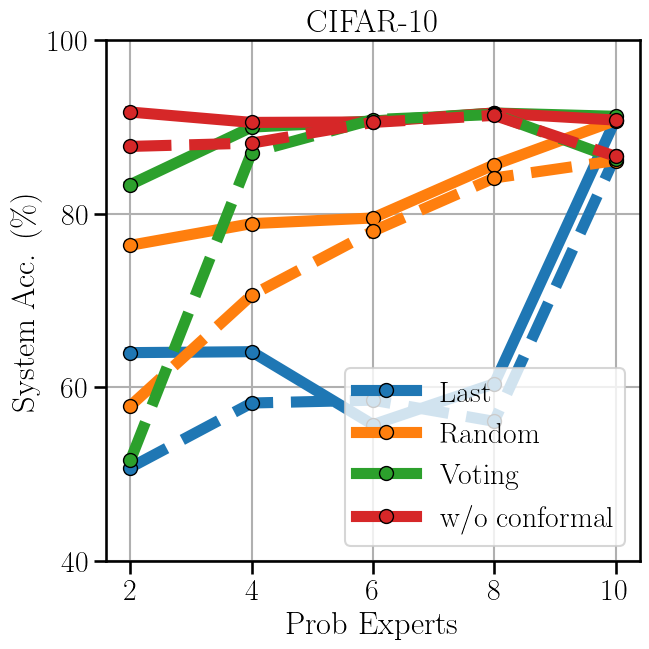

In [73]:
k_list = [2,4,6,8,10] #np.arange(1,11)


# OvA ===
sys_acc_standard_ova = np.array([method_d["system_accuracy"] for method_d in method_dict_ova["standard"]])
sys_acc_last_ova = np.array([method_d["system_accuracy"] for method_d in method_dict_ova["last"]])
sys_acc_random_ova = np.array([method_d["system_accuracy"] for method_d in method_dict_ova["random"]])
sys_acc_voting_ova = np.array([method_d["system_accuracy"] for method_d in method_dict_ova["voting"]])

# Softmax ===
sys_acc_standard_softmax = np.array([method_d["system_accuracy"] for method_d in method_dict_softmax["standard"]])
sys_acc_last_softmax = np.array([method_d["system_accuracy"] for method_d in method_dict_softmax["last"]])
sys_acc_random_softmax = np.array([method_d["system_accuracy"] for method_d in method_dict_softmax["random"]])
sys_acc_voting_softmax = np.array([method_d["system_accuracy"] for method_d in method_dict_softmax["voting"]])


f, ax = plt.subplots(1, 1, figsize=fig_size)
# OvA ===
ax.plot(k_list, sys_acc_last_ova, "-", label=r"Last", color=cm(0), **plot_args)
ax.plot(k_list, sys_acc_random_ova, "-", label=r"Random", color=cm(1), **plot_args)
ax.plot(k_list, sys_acc_voting_ova, "-", label=r"Voting", color=cm(2), **plot_args)
ax.plot(k_list, sys_acc_standard_ova, "-", label=r"w/o conformal", color=cm(3), **plot_args)

# Softmax ===
ax.plot(k_list, sys_acc_last_softmax, "--", color=cm(0), **plot_args)
ax.plot(k_list, sys_acc_random_softmax, "--", color=cm(1), **plot_args)
ax.plot(k_list, sys_acc_voting_softmax, "--", color=cm(2), **plot_args)
ax.plot(k_list, sys_acc_standard_softmax, "--", color=cm(3), **plot_args)

plt.xticks(k_list, k_list)
plt.yticks(list(plt.yticks()[0])[::2])
plt.ylabel(r'System Acc. ($\%$)')
plt.xlabel(r'Prob Experts')
plt.title(r"CIFAR-10")
plt.legend(loc="best")
plt.grid()
f.set_tight_layout(True)
plt.legend()

#plt.savefig("system_acc_increase_oracles.pdf")

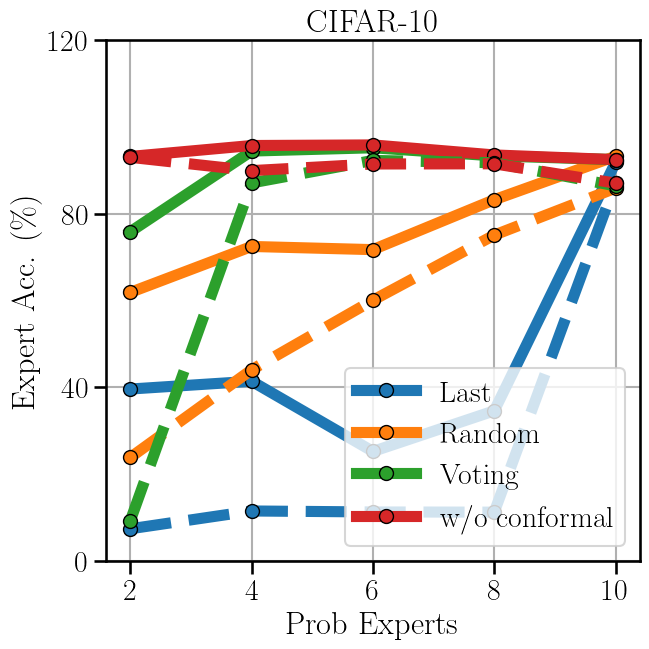

In [19]:
k_list

# OvA ===
exp_acc_standard_ova = np.array([method_d["expert_accuracy"] for method_d in method_dict_ova["standard"]])
exp_acc_last_ova = np.array([method_d["expert_accuracy"] for method_d in method_dict_ova["last"]])
exp_acc_random_ova = np.array([method_d["expert_accuracy"] for method_d in method_dict_ova["random"]])
exp_acc_voting_ova = np.array([method_d["expert_accuracy"] for method_d in method_dict_ova["voting"]])

# Softmax ===
exp_acc_standard_softmax = np.array([method_d["expert_accuracy"] for method_d in method_dict_softmax["standard"]])
exp_acc_last_softmax = np.array([method_d["expert_accuracy"] for method_d in method_dict_softmax["last"]])
exp_acc_random_softmax = np.array([method_d["expert_accuracy"] for method_d in method_dict_softmax["random"]])
exp_acc_voting_softmax = np.array([method_d["expert_accuracy"] for method_d in method_dict_softmax["voting"]])


f, ax = plt.subplots(1, 1, figsize=fig_size)
# OvA ===
ax.plot(k_list, exp_acc_last_ova, "-", label=r"Last", color=cm(0), **plot_args)
ax.plot(k_list, exp_acc_random_ova, "-", label=r"Random", color=cm(1), **plot_args)
ax.plot(k_list, exp_acc_voting_ova, "-", label=r"Voting", color=cm(2), **plot_args)
ax.plot(k_list, exp_acc_standard_ova, "-", label=r"w/o conformal", color=cm(3), **plot_args)

# Softmax ===
ax.plot(k_list, exp_acc_last_softmax, "--", color=cm(0), **plot_args)
ax.plot(k_list, exp_acc_random_softmax, "--", color=cm(1), **plot_args)
ax.plot(k_list, exp_acc_voting_softmax, "--", color=cm(2), **plot_args)
ax.plot(k_list, exp_acc_standard_softmax, "--", color=cm(3), **plot_args)

plt.xticks(k_list, k_list)
plt.yticks(list(plt.yticks()[0])[::2])
plt.ylabel(r'Expert Acc. ($\%$)')
plt.xlabel(r'Prob Experts')
plt.title(r"CIFAR-10")
plt.legend(loc="best")
plt.grid()
f.set_tight_layout(True)
plt.legend()

# plt.savefig("expert_acc_increase_oracles.pdf")


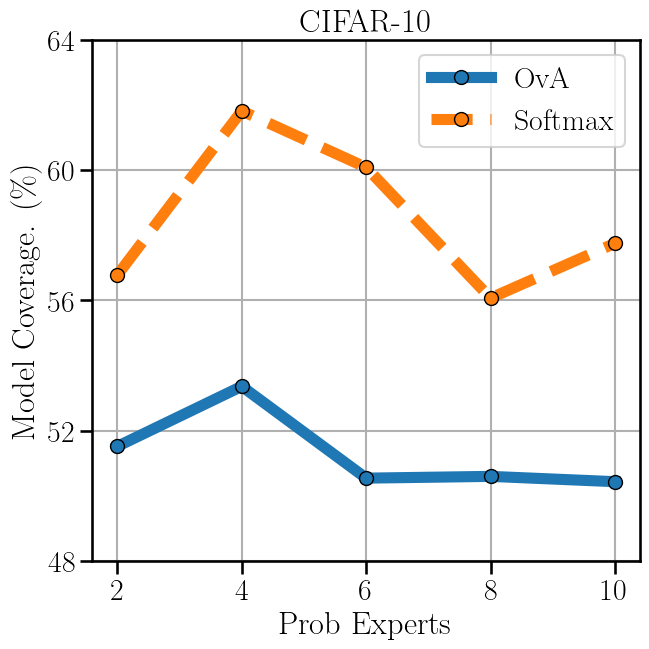

In [20]:
k_list
coverage_ova = np.array([method_d["coverage"] for method_d in method_dict_ova["last"]])
coverage_softmax = np.array([method_d["coverage"] for method_d in method_dict_softmax["last"]])

f, ax = plt.subplots(1, 1, figsize=fig_size)
ax.plot(k_list, coverage_ova, "-", label=r"OvA", **plot_args)
ax.plot(k_list, coverage_softmax, "--", label=r"Softmax", **plot_args)

plt.xticks(k_list, k_list)
plt.yticks(list(plt.yticks()[0])[::2])
plt.ylabel(r'Model Coverage. ($\%$)')
plt.xlabel(r'Prob Experts')
plt.title(r"CIFAR-10")
plt.legend(loc="best")
plt.grid()
f.set_tight_layout(True)
plt.legend()


#plt.savefig("coverage_increase_oracles.pdf")


In [21]:
# np.array([np.mean(method_d["set_size"]) for method_d in method_dict_ova["voting"]])

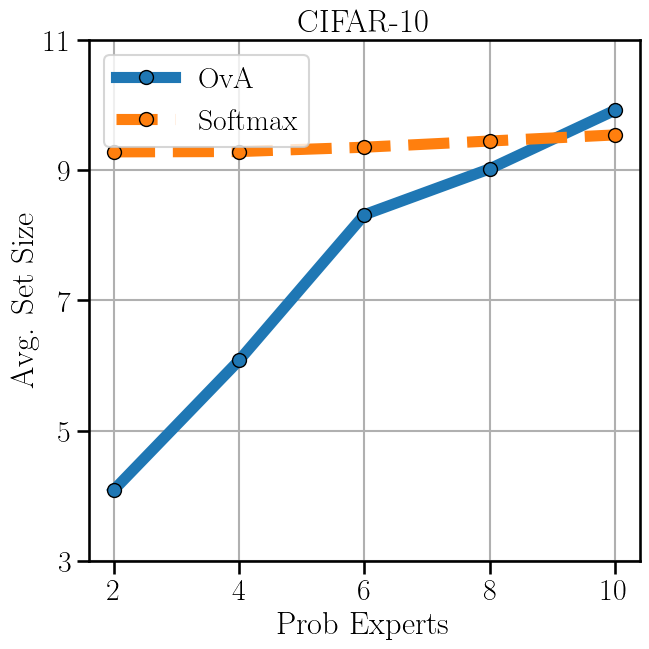

In [22]:
k_list
avg_set_size_ova = np.array([method_d["avg_set_size"] for method_d in method_dict_ova["random"]])
avg_set_size_softmax = np.array([method_d["avg_set_size"] for method_d in method_dict_softmax["random"]])

f, ax = plt.subplots(1, 1, figsize=fig_size)
ax.plot(k_list, avg_set_size_ova, "-", label=r"OvA", **plot_args)
ax.plot(k_list, avg_set_size_softmax, "--", label=r"Softmax", **plot_args)

plt.xticks(k_list, k_list)
plt.yticks(list(plt.yticks()[0])[::2])
plt.ylabel(r'Avg. Set Size')
plt.xlabel(r'Prob Experts')
plt.title(r"CIFAR-10")
plt.legend(loc="best")
plt.grid()
f.set_tight_layout(True)
plt.legend()


#plt.savefig("avg_set_size_increase_oracles.pdf")


In [23]:
# np.array([method_d["q_hat"] for method_d in method_dict_ova["last"]])

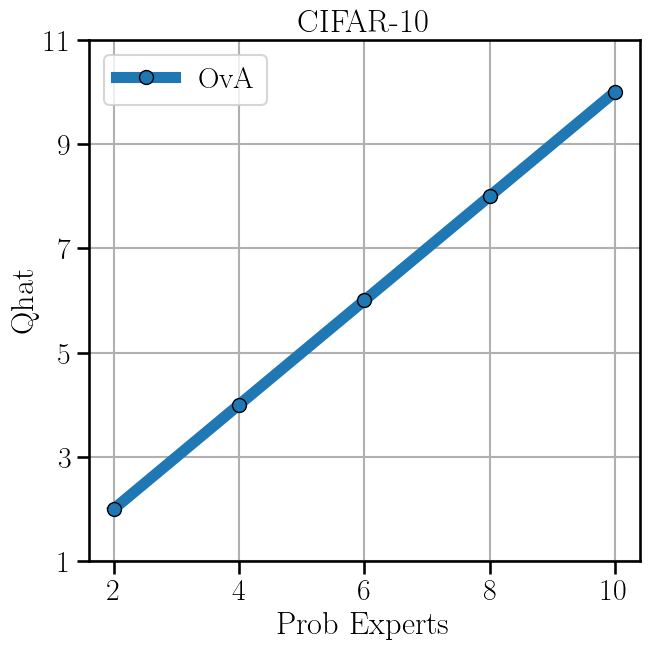

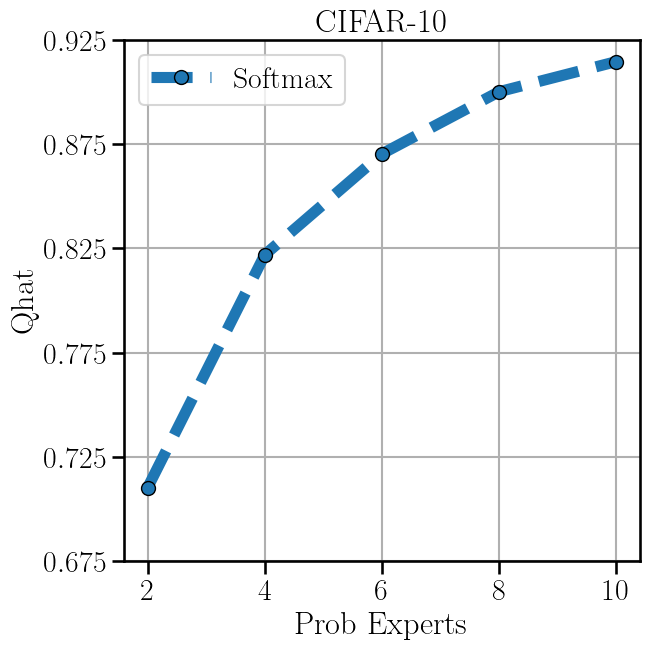

In [24]:
k_list
q_ova = np.array([method_d["q_hat"] for method_d in method_dict_ova["random"]])

f, ax = plt.subplots(1, 1, figsize=fig_size)
ax.plot(k_list, q_ova, "-", label=r"OvA", **plot_args)

plt.xticks(k_list, k_list)
plt.yticks(list(plt.yticks()[0])[::2])
plt.ylabel(r'Qhat')
plt.xlabel(r'Prob Experts')
plt.title(r"CIFAR-10")
plt.legend(loc="best")
plt.grid()
f.set_tight_layout(True)
plt.legend()


#plt.savefig("qhat_ova_increase_oracles.pdf")


q_ova_softmax = np.array([method_d["q_hat"] for method_d in method_dict_softmax["random"]])

f, ax = plt.subplots(1, 1, figsize=fig_size)
ax.plot(k_list, q_ova_softmax, "--", label=r"Softmax", **plot_args)

plt.xticks(k_list, k_list)
plt.yticks(list(plt.yticks()[0])[::2])
plt.ylabel(r'Qhat')
plt.xlabel(r'Prob Experts')
plt.title(r"CIFAR-10")
plt.legend(loc="best")
plt.grid()
f.set_tight_layout(True)
plt.legend()


#plt.savefig("qhat_softmax_increase_oracles.pdf")
